<a href="https://colab.research.google.com/github/sailikhithk/Tags-recommender-system-for-community-forums/blob/master/Sai's_code_Tag_Annotation_Deep_Learning_TF_IDF_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


#Pre-processing

In [ ]:
!pip install lime
!pip install transformers

## for data
import scipy
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

import re

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=aa974d0ec444a23d1bdaab45651b2f8fa9048f7e6b9e41718cf4a243a7628291
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 16.1MB/s 
     |████████████████████████████████| 890kB 33.8MB/s 
     |████████████████████████████████| 1.1MB 40.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=19594e9a2b061d0a5a09b72fe42472ecb3f38cae85c369b04ef1c91d9c60f060
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dtf = pd.read_csv('/drive/My Drive/Colab Notebooks/dataset25tags.csv')    # reading the csv file
dtf.head()      # printing first five rows of the file

,Text Title,Text content,Tags
0,Two neural network in tensorflow: TypeError: F...,I have seen similar problems descr...,python neural-network tensorflow reinforcement...
1,How can access to modify feature_importances o...,My goal is to extract the feature ...,python scikit-learn
2,KNN Regression: Distance function for datetime...,Take some datetime features like w...,regression
3,Multiple Time Series Forecasting with limited ...,I'm doing time series forecasting ...,machine-learning time-series
4,Association Rules,I'm using association rules for a ...,data-mining


In [ ]:
"""Data Overview"""

print('Rows x Columns : ', dtf.shape[0], 'x', dtf.shape[1])
print('Features: ', dtf.columns.tolist())
print('\nUnique values:')
print(dtf.nunique())

Rows x Columns :  10450 x 3
Features:  ['Text Title', 'Text content', 'Tags']

Unique values:
Text Title       9951
Text content    10047
Tags              903
dtype: int64


In [ ]:
"""type of entries and missing values"""

dtf.info()
print('\nMissing values:  ', dtf.isnull().sum().values.sum())
dtf.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Text Title    10450 non-null  object
 1   Text content  10450 non-null  object
 2   Tags          10450 non-null  object
dtypes: object(3)
memory usage: 245.0+ KB

Missing values:   0


Text Title      0
Text content    0
Tags            0
dtype: int64

In [ ]:
dtf.describe().T

,count,unique,top,freq
Text Title,10450,9951,Automated Scoring (non-english language) Using...,6
Text content,10450,10047,\ni'm a student and i'm new to NLP.\nI want to...,5
Tags,10450,903,machine-learning,1857


In [ ]:
# eliminate null values
dtf=dtf.replace(np.nan, 'Not Available')
dtf

,Text Title,Text content,Tags
0,Two neural network in tensorflow: TypeError: F...,I have seen similar problems descr...,python neural-network tensorflow reinforcement...
1,How can access to modify feature_importances o...,My goal is to extract the feature ...,python scikit-learn
2,KNN Regression: Distance function for datetime...,Take some datetime features like w...,regression
3,Multiple Time Series Forecasting with limited ...,I'm doing time series forecasting ...,machine-learning time-series
4,Association Rules,I'm using association rules for a ...,data-mining
...,...,...,...
10445,How to cluster when samples are independent an...,"\nIn machine learning, one can use Euclidean d...",machine-learning data-mining
10446,Implementation of Tree Kernels in Python,\nI'm looking to use a tree kernel (e.g. Zelen...,machine-learning python nlp statistics
10447,Classifier Chains,\nMy question is about creating classifier cha...,machine-learning
10448,Predictive analysis of rare events,"\nI'm trying to predict rare events, meaning l...",machine-learning predictive-modeling


In [ ]:
dtf['Text Title']=dtf['Text Title'].str.replace("[\n]", " ") 
dtf['Text content']=dtf['Text content'].str.replace("[\n]", " ") 

In [ ]:
dtf['Text content']=dtf['Text content'].str.strip()
dtf['Text Title']=dtf['Text Title'].str.strip()
dtf['Tags']=dtf['Tags'].str.strip()
dtf


,Text Title,Text content,Tags
0,Two neural network in tensorflow: TypeError: F...,I have seen similar problems describes typerro...,python neural-network tensorflow reinforcement...
1,How can access to modify feature_importances o...,My goal is to extract the feature importances ...,python scikit-learn
2,KNN Regression: Distance function for datetime...,Take some datetime features like week days (mo...,regression
3,Multiple Time Series Forecasting with limited ...,I'm doing time series forecasting for the sale...,machine-learning time-series
4,Association Rules,I'm using association rules for a project and ...,data-mining
...,...,...,...
10445,How to cluster when samples are independent an...,"In machine learning, one can use Euclidean dis...",machine-learning data-mining
10446,Implementation of Tree Kernels in Python,I'm looking to use a tree kernel (e.g. Zelenko...,machine-learning python nlp statistics
10447,Classifier Chains,My question is about creating classifier chain...,machine-learning
10448,Predictive analysis of rare events,"I'm trying to predict rare events, meaning les...",machine-learning predictive-modeling


In [ ]:
for i in range(len(dtf['Tags'])):
    dtf['Tags'][i]=list(dtf['Tags'][i].split(" "))
    #print(dtf['Tag'][i])

In [ ]:
dtf

,Text Title,Text content,Tags
0,Two neural network in tensorflow: TypeError: F...,I have seen similar problems describes typerro...,"[python, neural-network, tensorflow, reinforce..."
1,How can access to modify feature_importances o...,My goal is to extract the feature importances ...,"[python, scikit-learn]"
2,KNN Regression: Distance function for datetime...,Take some datetime features like week days (mo...,[regression]
3,Multiple Time Series Forecasting with limited ...,I'm doing time series forecasting for the sale...,"[machine-learning, time-series]"
4,Association Rules,I'm using association rules for a project and ...,[data-mining]
...,...,...,...
10445,How to cluster when samples are independent an...,"In machine learning, one can use Euclidean dis...","[machine-learning, data-mining]"
10446,Implementation of Tree Kernels in Python,I'm looking to use a tree kernel (e.g. Zelenko...,"[machine-learning, python, nlp, statistics]"
10447,Classifier Chains,My question is about creating classifier chain...,[machine-learning]
10448,Predictive analysis of rare events,"I'm trying to predict rare events, meaning les...","[machine-learning, predictive-modeling]"


## Pre-processed CSV is stored

In [ ]:
dtf.to_csv('out.csv',index=False)

In [ ]:
print(type(dtf['Tags']))

<class 'pandas.core.series.Series'>


In [ ]:
row=[]
for i in range(len(dtf['Tags'])):
    #print(dtf['Tag'][i])
    row.append(dtf['Tags'][i])
    
    

In [ ]:
tags=[]
for i in row:
    for j in i:
        tags.append(j.strip())

In [ ]:
all_tags=list(set(tags))

In [ ]:
len(all_tags)

25

In [ ]:
import nltk
all_tags = nltk.FreqDist(tags) 

In [ ]:
all_tags

FreqDist({'classification': 983,
          'clustering': 272,
          'cnn': 306,
          'computer-vision': 274,
          'convolutional-neural-networks': 388,
          'data-mining': 412,
          'dataset': 279,
          'deep-learning': 2932,
          'keras': 869,
          'machine-learning': 8261,
          'machine-learning-model': 265,
          'natural-language-processing': 582,
          'neural-network': 1317,
          'neural-networks': 750,
          'nlp': 374,
          'predictive-modeling': 367,
          'python': 1809,
          'r': 263,
          'regression': 465,
          'reinforcement-learning': 403,
          'scikit-learn': 564,
          'statistics': 272,
          'tensorflow': 629,
          'time-series': 349,
          'training': 265})

In [ ]:
# create dataframe
tags_df = pd.DataFrame({'Tags': list(all_tags.keys()), 
                              'Count': list(all_tags.values())})

In [ ]:
tags_df

,Tags,Count
0,python,1809
1,neural-network,1317
2,tensorflow,629
3,reinforcement-learning,403
4,scikit-learn,564
5,regression,465
6,machine-learning,8261
7,time-series,349
8,data-mining,412
9,deep-learning,2932


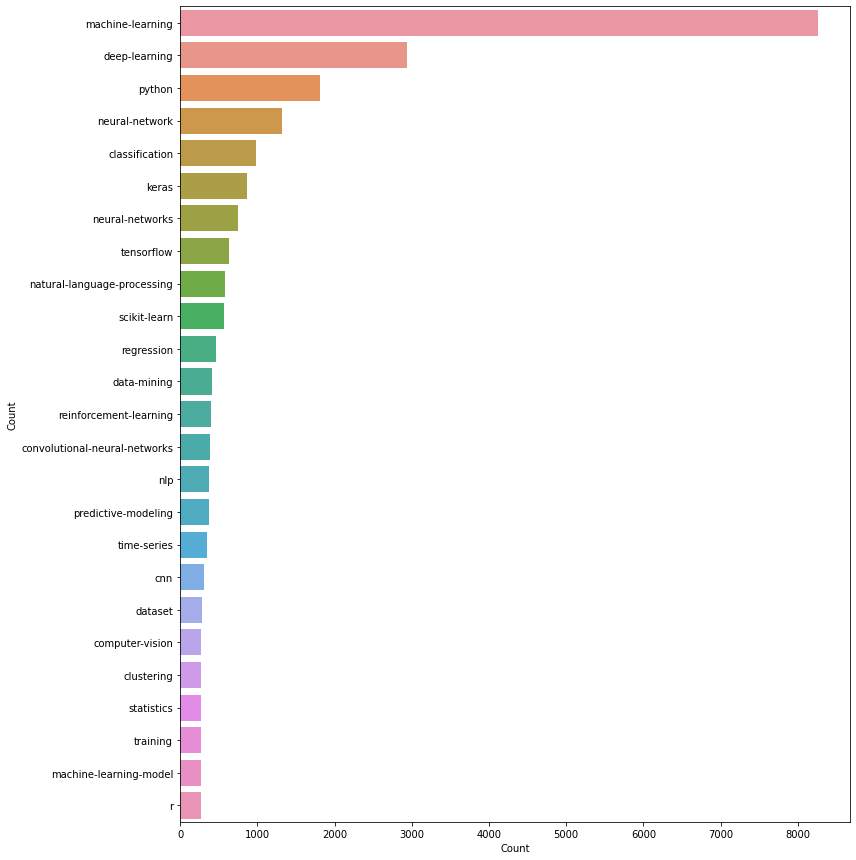

In [ ]:
g = tags_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Tags") 
ax.set(ylabel = 'Count') 
plt.show()

In [ ]:
#function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text



In [ ]:
# remove samples with 0 genre tags
tags_new = dtf[~(dtf['Tags'].str.len() == 0)]

In [ ]:
tags_new

,Text Title,Text content,Tags
0,Two neural network in tensorflow: TypeError: F...,I have seen similar problems describes typerro...,"[python, neural-network, tensorflow, reinforce..."
1,How can access to modify feature_importances o...,My goal is to extract the feature importances ...,"[python, scikit-learn]"
2,KNN Regression: Distance function for datetime...,Take some datetime features like week days (mo...,[regression]
3,Multiple Time Series Forecasting with limited ...,I'm doing time series forecasting for the sale...,"[machine-learning, time-series]"
4,Association Rules,I'm using association rules for a project and ...,[data-mining]
...,...,...,...
10445,How to cluster when samples are independent an...,"In machine learning, one can use Euclidean dis...","[machine-learning, data-mining]"
10446,Implementation of Tree Kernels in Python,I'm looking to use a tree kernel (e.g. Zelenko...,"[machine-learning, python, nlp, statistics]"
10447,Classifier Chains,My question is about creating classifier chain...,[machine-learning]
10448,Predictive analysis of rare events,"I'm trying to predict rare events, meaning les...","[machine-learning, predictive-modeling]"


In [ ]:
tags_new['Cleaned Text Title'] = tags_new['Text Title'].apply(lambda x: clean_text(x))
tags_new

,Text Title,Text content,Tags,Cleaned Text Title
0,Two neural network in tensorflow: TypeError: F...,I have seen similar problems describes typerro...,"[python, neural-network, tensorflow, reinforce...",two neural network in tensorflow typeerror fet...
1,How can access to modify feature_importances o...,My goal is to extract the feature importances ...,"[python, scikit-learn]",how can access to modify feature importances o...
2,KNN Regression: Distance function for datetime...,Take some datetime features like week days (mo...,[regression],knn regression distance function for datetime ...
3,Multiple Time Series Forecasting with limited ...,I'm doing time series forecasting for the sale...,"[machine-learning, time-series]",multiple time series forecasting with limited ...
4,Association Rules,I'm using association rules for a project and ...,[data-mining],association rules
...,...,...,...,...
10445,How to cluster when samples are independent an...,"In machine learning, one can use Euclidean dis...","[machine-learning, data-mining]",how to cluster when samples are independent an...
10446,Implementation of Tree Kernels in Python,I'm looking to use a tree kernel (e.g. Zelenko...,"[machine-learning, python, nlp, statistics]",implementation of tree kernels in python
10447,Classifier Chains,My question is about creating classifier chain...,[machine-learning],classifier chains
10448,Predictive analysis of rare events,"I'm trying to predict rare events, meaning les...","[machine-learning, predictive-modeling]",predictive analysis of rare events


## Remove stop words

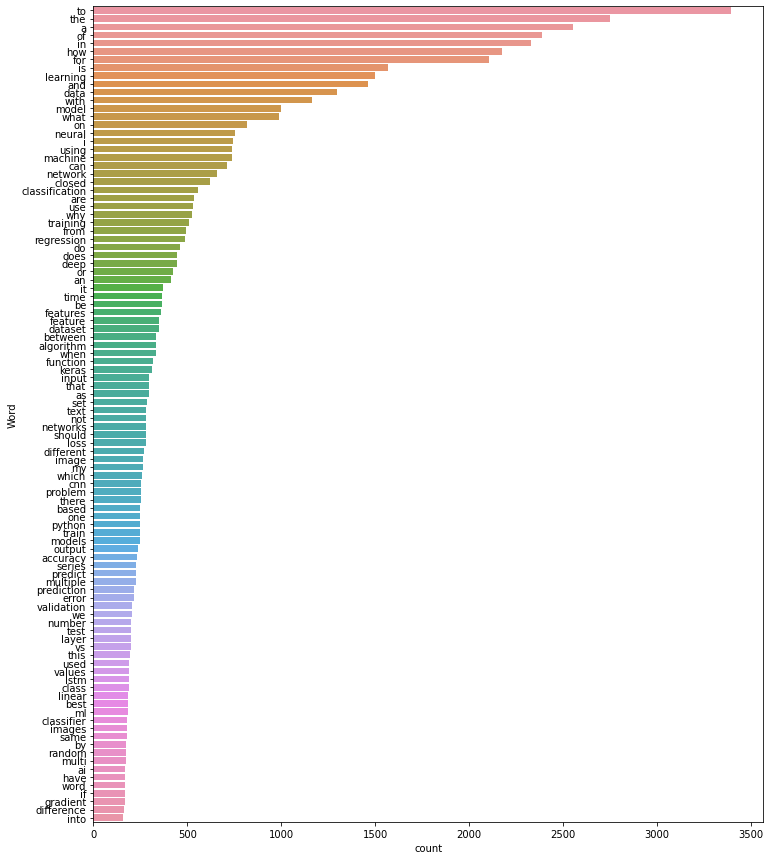

In [ ]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

# print 100 most frequent words 
freq_words(tags_new['Cleaned Text Title'], 100)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

tags_new['Cleaned Text Title'] = tags_new['Cleaned Text Title'].apply(lambda x: remove_stopwords(x))

In [ ]:
tags_new

,Text Title,Text content,Tags,Cleaned Text Title
0,Two neural network in tensorflow: TypeError: F...,I have seen similar problems describes typerro...,"[python, neural-network, tensorflow, reinforce...",two neural network tensorflow typeerror fetch ...
1,How can access to modify feature_importances o...,My goal is to extract the feature importances ...,"[python, scikit-learn]",access modify feature importances random fores...
2,KNN Regression: Distance function for datetime...,Take some datetime features like week days (mo...,[regression],knn regression distance function datetime feat...
3,Multiple Time Series Forecasting with limited ...,I'm doing time series forecasting for the sale...,"[machine-learning, time-series]",multiple time series forecasting limited data
4,Association Rules,I'm using association rules for a project and ...,[data-mining],association rules
...,...,...,...,...
10445,How to cluster when samples are independent an...,"In machine learning, one can use Euclidean dis...","[machine-learning, data-mining]",cluster samples independent dimensions indepen...
10446,Implementation of Tree Kernels in Python,I'm looking to use a tree kernel (e.g. Zelenko...,"[machine-learning, python, nlp, statistics]",implementation tree kernels python
10447,Classifier Chains,My question is about creating classifier chain...,[machine-learning],classifier chains
10448,Predictive analysis of rare events,"I'm trying to predict rare events, meaning les...","[machine-learning, predictive-modeling]",predictive analysis rare events


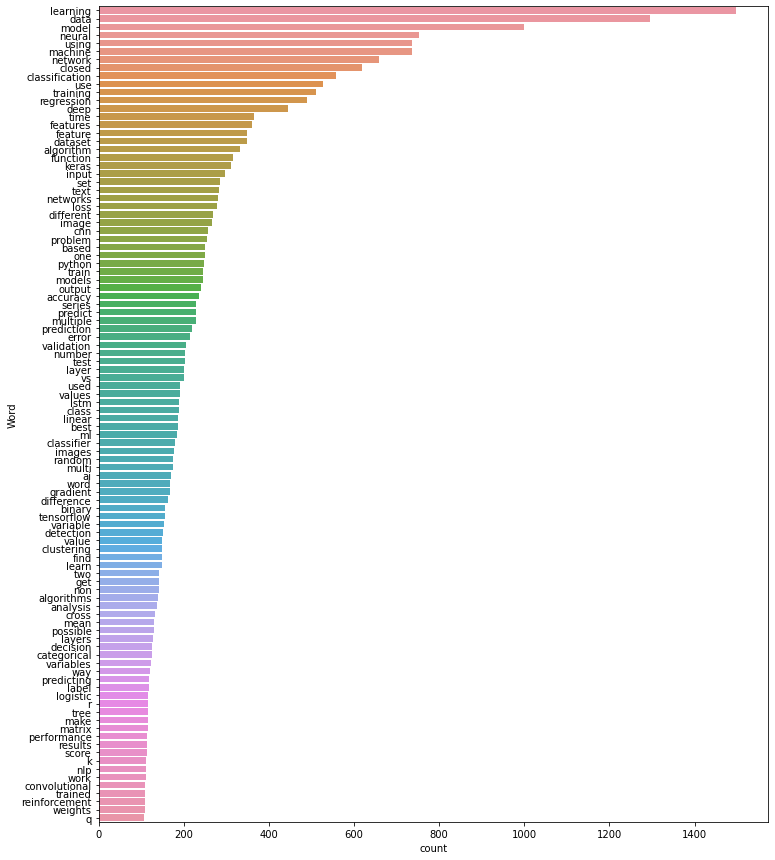

In [ ]:
freq_words(tags_new['Cleaned Text Title'], 100)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(tags_new['Tags'])

# transform target variable
y = multilabel_binarizer.transform(tags_new['Tags'])

# Modelling


In [ ]:
y

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=5000)

print(tfidf_vectorizer)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


In [ ]:
tfidf_vectorizer
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier


# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(tags_new['Cleaned Text Title'], y, test_size=0.2, random_state=9)



In [ ]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric

from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score



In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [ ]:
#make prediction for training dataset
clf.fit(xtrain_tfidf, ytrain)

y_pred_train = clf.predict(xtrain_tfidf)

print('Train Accuracy:', accuracy_score(ytrain, y_pred_train))
print('Train F1:', f1_score(ytrain, y_pred_train, average='micro'))

Train Accuracy: 0.2297846889952153
Train F1: 0.5979872161022712


In [ ]:
# make predictions for validation set
y_pred_val = clf.predict(xval_tfidf)
print('Train Accuracy:', accuracy_score(yval, y_pred_val))
print('Train F1:', f1_score(yval, y_pred_val, average='micro'))

Train Accuracy: 0.21339712918660286
Train F1: 0.558215451577802


In [ ]:
y_pred_val[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [ ]:
multilabel_binarizer.inverse_transform(y_pred_val)[3]

('machine-learning',)

In [ ]:
# evaluate performance
f1_score(yval, y_pred_val, average="micro")

0.558215451577802

In [ ]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [ ]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [ ]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.6130854318663215

In [ ]:
#print(clf.intercept_)
#print(clf.coef_)

RSS = np.mean((y_pred_new-yval)**2)/(np.std(yval)**2)
Rsq = 1-RSS

print("RSS per sample = {0:f}".format(RSS))
print("R^2 =            {0:f}".format(Rsq))

RSS per sample = 0.762877
R^2 =            0.237123


In [ ]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [ ]:
tags_new

,Text Title,Text content,Tags,Cleaned Text Title
0,Two neural network in tensorflow: TypeError: F...,I have seen similar problems describes typerro...,"[python, neural-network, tensorflow, reinforce...",two neural network tensorflow typeerror fetch ...
1,How can access to modify feature_importances o...,My goal is to extract the feature importances ...,"[python, scikit-learn]",access modify feature importances random fores...
2,KNN Regression: Distance function for datetime...,Take some datetime features like week days (mo...,[regression],knn regression distance function datetime feat...
3,Multiple Time Series Forecasting with limited ...,I'm doing time series forecasting for the sale...,"[machine-learning, time-series]",multiple time series forecasting limited data
4,Association Rules,I'm using association rules for a project and ...,[data-mining],association rules
...,...,...,...,...
10445,How to cluster when samples are independent an...,"In machine learning, one can use Euclidean dis...","[machine-learning, data-mining]",cluster samples independent dimensions indepen...
10446,Implementation of Tree Kernels in Python,I'm looking to use a tree kernel (e.g. Zelenko...,"[machine-learning, python, nlp, statistics]",implementation tree kernels python
10447,Classifier Chains,My question is about creating classifier chain...,[machine-learning],classifier chains
10448,Predictive analysis of rare events,"I'm trying to predict rare events, meaning les...","[machine-learning, predictive-modeling]",predictive analysis rare events


In [ ]:
for i in range(30): 
    k = xval.sample(1).index[0] 
    print("Tags: ", tags_new['Text Title'][k], "\nPredicted tags: ", infer_tags(xval[k])), print("Actual tags: ",tags_new['Tags'][k], "\n")


Tags:  Combining neural networks with different variables 
Predicted tags:  [('machine-learning', 'neural-network')]
Actual tags:  ['machine-learning', 'neural-network'] 

Tags:  Learning to Rank Application 
Predicted tags:  [('machine-learning',)]
Actual tags:  ['machine-learning'] 

Tags:  Can a trained Vid2Vid model be run on AMDs Ryzen 2700x with 32GB of RAM? 
Predicted tags:  [('machine-learning',)]
Actual tags:  ['deep-learning'] 

Tags:  Overfitting in CNN 
Predicted tags:  [('cnn', 'machine-learning')]
Actual tags:  ['machine-learning', 'deep-learning', 'neural-network', 'tensorflow'] 

Tags:  How does a zero centered activation functions like tanh helps in gradient decent? 
Predicted tags:  [('deep-learning', 'machine-learning')]
Actual tags:  ['machine-learning'] 

Tags:  Add new attribute to the input of nerual network 
Predicted tags:  [()]
Actual tags:  ['machine-learning', 'deep-learning', 'neural-network'] 

Tags:  Problem fitting data using mlpregressor 
Predicted tags

#Custom Text for prediction:

In [ ]:
array=[]
print("enter no. of texts you wanted to predict?")
n=int(input())
for i in range(n):
  print("Enter your Text:"+str(i+1))
  array.append(str(input()))

#array=["Using neural-networks, deep learning and machine learning makes my life easier","python is easier than javascript while doing machine learning"]
dataframe=pd.DataFrame(array, columns=["Text Title"])
dataframe

enter no. of texts you wanted to predict?
1
Enter your Text:1
Hello mates, how do you do this in keras?


,Text Title
0,"Hello mates, how do you do this in keras?"


In [ ]:
for i in range(n):
    print("Tags: ", dataframe['Text Title'][i], "\nPredicted tags: ", infer_tags(dataframe['Text Title'][i]))

Tags:  Hello mates, how do you do this in keras? 
Predicted tags:  [('keras', 'machine-learning', 'python', 'tensorflow')]
